#### Loading the necessary libraries and packages

In [1]:
# Load tensorflow
import tensorflow as tf
# Below command is to avoid the known bug which prevents computation on some GPU devices
physical_devices = tf.config.experimental.list_physical_devices('GPU')
assert len(physical_devices) > 0, "Not enough GPU hardware devices available"
tf.config.experimental.set_memory_growth(physical_devices[0], True)
# Load preprocessing tools
from tensorflow.keras.utils import Sequence
from scipy.ndimage.filters import gaussian_filter
from PIL import Image
# Load model building blocks
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
# Load pre-trained model library
from tensorflow.keras import applications
# Load miscelaneous libraries
import numpy as np
import os
import matplotlib.pylab as plt
import gc

#### Data preprocessing and augmentation

Load the data from the directory. The data are the images of particles split into subdirectories based on the number of forces acting on the particle. The labels should be loaded from a separate directory. Each label corresponds to two particles. 

The size of all images is adjusted so that all images are 128*128 using nearest neighbor interpolation. Validation split is performed: 20% is set aside for validation. Additionally images are blurred using Gaussian blur with kernel radius = 1.The pixel values are scaled using 1/255 to be in the interval [0,1].

In [2]:
# Define sorter of image names in order by image number (default is alphanumric)
def sorter(item):
    # Since highest marks first, least error = most marks
    radius = float(item[1 : item.find('_')])
    num_img = int(item[item.find('g') + 1 : item.find('j') - 1])
    return (radius, num_img)

In [3]:
# Load the train and validation sets

X_train, X_val = {}, {}
y_train, y_val = {}, {}

for k in range(5):
    i = k + 2
    X_path_train = os.path.join(os.getcwd(), 'image_data', 'train', str(i))
    X_path_val = os.path.join(os.getcwd(), 'image_data', 'val', str(i))
    X_train[i] = [os.path.join(X_path_train, name) for name in sorted(os.listdir(X_path_train), key = sorter)]
    X_val[i] = [os.path.join(X_path_val, name) for name in sorted(os.listdir(X_path_val), key = sorter)]
    y_train[i] = np.load(os.path.join(os.getcwd(), 'labels', 'train', str(i), 'mags.npy'))
    y_val[i] = np.load(os.path.join(os.getcwd(), 'labels', 'val', str(i), 'mags.npy'))

In [4]:
# Define class for data generation
class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_image_paths = None, labels = None,  
                 batch_size = 32, dim = None, n_channels = 3, rescale = 1, 
                 shuffle=True, save_dir = None, preprocessing_func = None):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.list_image_paths = list_image_paths
        self.n_channels = n_channels
        self.rescale = rescale
        self.shuffle = shuffle
        self.save_dir = save_dir
        self.preprocessing_func = preprocessing_func
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_image_paths) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indices = self.indices[index * self.batch_size : (index + 1) * self.batch_size]

        # Generate data
        X, y = self.__data_generation(indices)
        
        if self.save_dir is not None:
            for i in range(X.shape[0]):
                path = os.path.join(self.save_dir, 'img' + str(i) + '.jpg')
                plt.imsave(path, np.asarray(X[i, ]), vmin = 0, vmax = 1)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indices = np.arange(len(self.list_image_paths))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def __data_generation(self, indices):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        
        # Initialisation
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        list_image_paths_batch = [self.list_image_paths[k] for k in indices]
        
        # Get labels
        y = np.array([self.labels[k, :] for k in indices])
        
        # Generate data
        for i, image_path in enumerate(list_image_paths_batch):
            # Load image and transform
            image = Image.open(os.path.join(image_path))
            if self.dim is not None:
                image = image.resize(self.dim, resample = Image.NEAREST)
            image = np.array(image)[:, :, :self.n_channels]
            image = image * self.rescale
            if self.preprocessing_func is not None:
                image = self.preprocessing_func(image)
            # Store sample
            X[i,] = image

        return X, y

In [5]:
# Define gaussian blur class
class GaussBlur:
    def __init__(self, radius):
        self.radius = radius
    def blur(self, image):
        return gaussian_filter(image, sigma = self.radius)

In [6]:
# Apply data generators
gaussblur = GaussBlur(1)
params = {'batch_size': 32, 
          'dim': (128, 128), 
          'n_channels': 3, 
          'rescale': 1 / 255, 
          'shuffle': True, 
          'save_dir': None,
          'preprocessing_func': gaussblur.blur
          }

training_generator = {}
validation_generator = {}

for k in range(5):
    i = k + 2
    training_generator[i] = DataGenerator(X_train[i], y_train[i], **params)
    validation_generator[i] = DataGenerator(X_val[i], y_val[i], **params) 

[1.00702309 1.00702309]
[0.53773462 0.47715679 0.43368329]
[0.07165182 0.0582141  0.02442762 0.06981183]
[0.04950483 0.03749359 0.06012895 0.03888121 0.06487915]
[0.31405079 0.25099765 0.21632166 0.24008321 0.22162574 0.22722441]


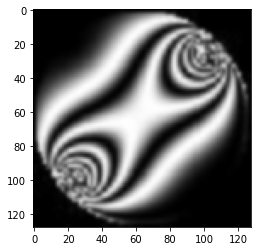

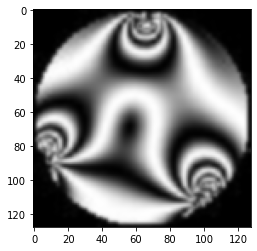

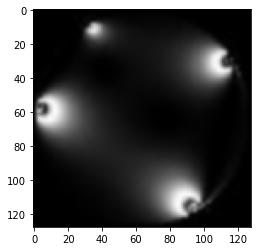

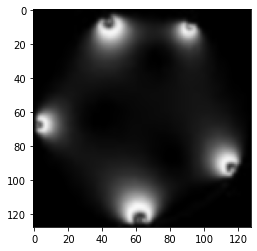

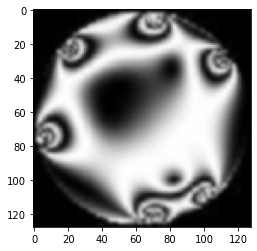

In [7]:
# Generate a sample of images for inspection

test_generator = {}
for k in range(5):
    i = k + 2
    test_generator[i] = DataGenerator(X_train[i], y_train[i], **params)
    x, y = test_generator[i].__getitem__(0)
    plt.figure()
    plt.imshow(np.asarray(x[3, ]))
    print(y[3])

#### VGG19 Models Building

Convolutional neural networks is defined and compiled in this step.

In [8]:
base_model = {}

# Load VGG19 model to be the base model
for k in range(5):
    i = k + 2
    base_model[i] = applications.VGG19(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        input_shape=(128, 128, 3),
        include_top=False)
    base_model[i].trainable = False

In [9]:
# Define the model
model = {}
for k in range(5):
    i = k + 2
    inputs = Input(shape=(128, 128, 3))
    x = base_model[i](inputs, training = False)
    x = Flatten()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(i, activation='linear')(x)
    model[i] = Model(inputs, outputs)

In [10]:
for k in range(5):
    i = k + 2
    model[i].summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 28,416,066
Trainable params: 8,391,682
Non-trainable params: 20,024,384
_________________________________________

#### VGG19 Model Training

The model is trained using Adam optimizer. The loss is defined to be mean absolute error. Best model selection across training epochs is implemented with model checkpoint tracking the validation loss. Early stopping is set with patience of 30 epochs. 

In [11]:
for k in range(5):
    i = 2 + k
    model[i].compile(optimizer=tf.keras.optimizers.Adam(),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])

In [12]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = dict()
for k in range(5):
    i = k + 2
    save_dir = os.path.join(os.getcwd(), 'models')
    model_name = 'vgg19_mags_'+str(i)+'.h5'
    model_path = os.path.join(save_dir, model_name)
    mc[i] = ModelCheckpoint(model_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)

In [13]:
epochs = 200
history = {}

for k in range(5):
    i = k + 2
    print('Model for ', i, ' angles')
    history[i] = model[i].fit(training_generator[i],
                            validation_data = validation_generator[i],
                            epochs = epochs,
                            steps_per_epoch = len(training_generator[i]),
                            validation_steps = len(validation_generator[i]),
                            callbacks=[es, mc[i]]
                           )

Model for  2  angles
Epoch 1/200
500/500 [==============================] - ETA: 0s - loss: 0.1858 - mean_absolute_error: 0.1858
Epoch 00001: val_loss improved from inf to 0.04845, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/vgg19_mags_2.h5
500/500 [==============================] - 42s 84ms/step - loss: 0.1858 - mean_absolute_error: 0.1858 - val_loss: 0.0485 - val_mean_absolute_error: 0.0485
Epoch 2/200
500/500 [==============================] - ETA: 0s - loss: 0.0737 - mean_absolute_error: 0.0737
Epoch 00002: val_loss improved from 0.04845 to 0.04455, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/vgg19_mags_2.h5
500/500 [==============================] - 42s 84ms/step - loss: 0.0737 - mean_absolute_error: 0.0737 - val_loss: 0.0445 - val_mean_absolute_error: 0.0445
Epoch 3/200
500/500 [==============================] - ETA: 0s - loss: 0.0745 - mean_absolute_error: 0.0745
Epoch 00003: val_loss improved from

Epoch 25/200
500/500 [==============================] - ETA: 0s - loss: 0.0723 - mean_absolute_error: 0.0723
Epoch 00025: val_loss did not improve from 0.01724
500/500 [==============================] - 41s 82ms/step - loss: 0.0723 - mean_absolute_error: 0.0723 - val_loss: 0.0301 - val_mean_absolute_error: 0.0301
Epoch 26/200
500/500 [==============================] - ETA: 0s - loss: 0.0739 - mean_absolute_error: 0.0739
Epoch 00026: val_loss did not improve from 0.01724
500/500 [==============================] - 40s 81ms/step - loss: 0.0739 - mean_absolute_error: 0.0739 - val_loss: 0.0435 - val_mean_absolute_error: 0.0435
Epoch 27/200
500/500 [==============================] - ETA: 0s - loss: 0.0720 - mean_absolute_error: 0.0720
Epoch 00027: val_loss did not improve from 0.01724
500/500 [==============================] - 41s 82ms/step - loss: 0.0720 - mean_absolute_error: 0.0720 - val_loss: 0.0337 - val_mean_absolute_error: 0.0337
Epoch 28/200
500/500 [==============================] -

Epoch 14/200
500/500 [==============================] - ETA: 0s - loss: 0.1010 - mean_absolute_error: 0.1010
Epoch 00014: val_loss did not improve from 0.05601
500/500 [==============================] - 41s 83ms/step - loss: 0.1010 - mean_absolute_error: 0.1010 - val_loss: 0.0638 - val_mean_absolute_error: 0.0638
Epoch 15/200
500/500 [==============================] - ETA: 0s - loss: 0.1001 - mean_absolute_error: 0.1001
Epoch 00015: val_loss did not improve from 0.05601
500/500 [==============================] - 41s 82ms/step - loss: 0.1001 - mean_absolute_error: 0.1001 - val_loss: 0.0657 - val_mean_absolute_error: 0.0657
Epoch 16/200
500/500 [==============================] - ETA: 0s - loss: 0.1011 - mean_absolute_error: 0.1011
Epoch 00016: val_loss improved from 0.05601 to 0.05421, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/vgg19_mags_3.h5
500/500 [==============================] - 41s 82ms/step - loss: 0.1011 - mean_absolute_error: 0.1011 - 

Epoch 39/200
500/500 [==============================] - ETA: 0s - loss: 0.0994 - mean_absolute_error: 0.0994
Epoch 00039: val_loss did not improve from 0.05329
500/500 [==============================] - 41s 82ms/step - loss: 0.0994 - mean_absolute_error: 0.0994 - val_loss: 0.0623 - val_mean_absolute_error: 0.0623
Epoch 40/200
500/500 [==============================] - ETA: 0s - loss: 0.0993 - mean_absolute_error: 0.0993
Epoch 00040: val_loss did not improve from 0.05329
500/500 [==============================] - 41s 83ms/step - loss: 0.0993 - mean_absolute_error: 0.0993 - val_loss: 0.0544 - val_mean_absolute_error: 0.0544
Epoch 41/200
500/500 [==============================] - ETA: 0s - loss: 0.0998 - mean_absolute_error: 0.0998
Epoch 00041: val_loss did not improve from 0.05329
500/500 [==============================] - 41s 82ms/step - loss: 0.0998 - mean_absolute_error: 0.0998 - val_loss: 0.0645 - val_mean_absolute_error: 0.0645
Epoch 42/200
500/500 [==============================] -

Epoch 64/200
500/500 [==============================] - ETA: 0s - loss: 0.0988 - mean_absolute_error: 0.0988
Epoch 00064: val_loss did not improve from 0.04938
500/500 [==============================] - 40s 80ms/step - loss: 0.0988 - mean_absolute_error: 0.0988 - val_loss: 0.0586 - val_mean_absolute_error: 0.0586
Epoch 65/200
500/500 [==============================] - ETA: 0s - loss: 0.0990 - mean_absolute_error: 0.0990
Epoch 00065: val_loss did not improve from 0.04938
500/500 [==============================] - 41s 83ms/step - loss: 0.0990 - mean_absolute_error: 0.0990 - val_loss: 0.0586 - val_mean_absolute_error: 0.0586
Epoch 66/200
500/500 [==============================] - ETA: 0s - loss: 0.0996 - mean_absolute_error: 0.0996
Epoch 00066: val_loss did not improve from 0.04938
500/500 [==============================] - 41s 82ms/step - loss: 0.0996 - mean_absolute_error: 0.0996 - val_loss: 0.0569 - val_mean_absolute_error: 0.0569
Epoch 67/200
499/500 [============================>.] -

500/500 [==============================] - ETA: 0s - loss: 0.0807 - mean_absolute_error: 0.0807
Epoch 00026: val_loss did not improve from 0.05151
500/500 [==============================] - 42s 84ms/step - loss: 0.0807 - mean_absolute_error: 0.0807 - val_loss: 0.0520 - val_mean_absolute_error: 0.0520
Epoch 27/200
500/500 [==============================] - ETA: 0s - loss: 0.0796 - mean_absolute_error: 0.0796
Epoch 00027: val_loss did not improve from 0.05151
500/500 [==============================] - 42s 83ms/step - loss: 0.0796 - mean_absolute_error: 0.0796 - val_loss: 0.0528 - val_mean_absolute_error: 0.0528
Epoch 28/200
499/500 [============================>.] - ETA: 0s - loss: 0.0808 - mean_absolute_error: 0.0808
Epoch 00028: val_loss did not improve from 0.05151
500/500 [==============================] - 41s 82ms/step - loss: 0.0808 - mean_absolute_error: 0.0808 - val_loss: 0.0518 - val_mean_absolute_error: 0.0518
Epoch 29/200
500/500 [==============================] - ETA: 0s - lo

Epoch 52/200
500/500 [==============================] - ETA: 0s - loss: 0.0799 - mean_absolute_error: 0.0799
Epoch 00052: val_loss did not improve from 0.04991
500/500 [==============================] - 41s 83ms/step - loss: 0.0799 - mean_absolute_error: 0.0799 - val_loss: 0.0521 - val_mean_absolute_error: 0.0521
Epoch 53/200
500/500 [==============================] - ETA: 0s - loss: 0.0804 - mean_absolute_error: 0.0804
Epoch 00053: val_loss did not improve from 0.04991
500/500 [==============================] - 40s 81ms/step - loss: 0.0804 - mean_absolute_error: 0.0804 - val_loss: 0.0662 - val_mean_absolute_error: 0.0662
Epoch 54/200
499/500 [============================>.] - ETA: 0s - loss: 0.0802 - mean_absolute_error: 0.0802
Epoch 00054: val_loss did not improve from 0.04991
500/500 [==============================] - 41s 82ms/step - loss: 0.0802 - mean_absolute_error: 0.0802 - val_loss: 0.0570 - val_mean_absolute_error: 0.0570
Epoch 55/200
500/500 [==============================] -

Epoch 19/200
500/500 [==============================] - ETA: 0s - loss: 0.0804 - mean_absolute_error: 0.0804
Epoch 00019: val_loss improved from 0.05764 to 0.05473, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/vgg19_mags_5.h5
500/500 [==============================] - 41s 83ms/step - loss: 0.0804 - mean_absolute_error: 0.0804 - val_loss: 0.0547 - val_mean_absolute_error: 0.0547
Epoch 20/200
500/500 [==============================] - ETA: 0s - loss: 0.0796 - mean_absolute_error: 0.0796
Epoch 00020: val_loss did not improve from 0.05473
500/500 [==============================] - 42s 83ms/step - loss: 0.0796 - mean_absolute_error: 0.0796 - val_loss: 0.0584 - val_mean_absolute_error: 0.0584
Epoch 21/200
500/500 [==============================] - ETA: 0s - loss: 0.0799 - mean_absolute_error: 0.0799
Epoch 00021: val_loss did not improve from 0.05473
500/500 [==============================] - 41s 83ms/step - loss: 0.0799 - mean_absolute_error: 0.0799 - 

Epoch 5/200
500/500 [==============================] - ETA: 0s - loss: 0.0822 - mean_absolute_error: 0.0822
Epoch 00005: val_loss did not improve from 0.04828
500/500 [==============================] - 40s 80ms/step - loss: 0.0822 - mean_absolute_error: 0.0822 - val_loss: 0.0495 - val_mean_absolute_error: 0.0495
Epoch 6/200
500/500 [==============================] - ETA: 0s - loss: 0.0827 - mean_absolute_error: 0.0827
Epoch 00006: val_loss did not improve from 0.04828
500/500 [==============================] - 41s 82ms/step - loss: 0.0827 - mean_absolute_error: 0.0827 - val_loss: 0.0512 - val_mean_absolute_error: 0.0512
Epoch 7/200
500/500 [==============================] - ETA: 0s - loss: 0.0828 - mean_absolute_error: 0.0828
Epoch 00007: val_loss did not improve from 0.04828
500/500 [==============================] - 41s 83ms/step - loss: 0.0828 - mean_absolute_error: 0.0828 - val_loss: 0.0577 - val_mean_absolute_error: 0.0577
Epoch 8/200
500/500 [==============================] - ETA

499/500 [============================>.] - ETA: 0s - loss: 0.0824 - mean_absolute_error: 0.0824
Epoch 00030: val_loss did not improve from 0.04631
500/500 [==============================] - 41s 82ms/step - loss: 0.0824 - mean_absolute_error: 0.0824 - val_loss: 0.0534 - val_mean_absolute_error: 0.0534
Epoch 31/200
500/500 [==============================] - ETA: 0s - loss: 0.0821 - mean_absolute_error: 0.0821
Epoch 00031: val_loss did not improve from 0.04631
500/500 [==============================] - 40s 80ms/step - loss: 0.0821 - mean_absolute_error: 0.0821 - val_loss: 0.0495 - val_mean_absolute_error: 0.0495
Epoch 32/200
499/500 [============================>.] - ETA: 0s - loss: 0.0827 - mean_absolute_error: 0.0827
Epoch 00032: val_loss did not improve from 0.04631
500/500 [==============================] - 41s 81ms/step - loss: 0.0827 - mean_absolute_error: 0.0827 - val_loss: 0.0482 - val_mean_absolute_error: 0.0482
Epoch 33/200
499/500 [============================>.] - ETA: 0s - lo

#### VGG19 Model Fine-tuning

In [14]:
for k in range(5):
    i = k + 2
    base_model[i].trainable = True
    model[i].summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2050      
Total params: 28,416,066
Trainable params: 28,416,066
Non-trainable params: 0
_________________________________________________

In [15]:
for k in range(5):
    i = 2 + k
    model[i].compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5, epsilon=1e-7),
              loss='mean_absolute_error',
              metrics=['mean_absolute_error'])

In [16]:
epochs = 100
history_ft = {}

for k in range(5):
    i = k + 2
    print('Model for ', i, ' angles')
    history_ft[i] = model[i].fit(training_generator[i],
                            validation_data = validation_generator[i],
                            epochs = epochs,
                            steps_per_epoch = len(training_generator[i]),
                            validation_steps = len(validation_generator[i]),
                            callbacks=[es, mc[i]]
                           )

Model for  2  angles
Epoch 1/100
500/500 [==============================] - ETA: 0s - loss: 0.0691 - mean_absolute_error: 0.0691
Epoch 00001: val_loss did not improve from 0.01724
500/500 [==============================] - 56s 111ms/step - loss: 0.0691 - mean_absolute_error: 0.0691 - val_loss: 0.0285 - val_mean_absolute_error: 0.0285
Epoch 2/100
500/500 [==============================] - ETA: 0s - loss: 0.0592 - mean_absolute_error: 0.0592
Epoch 00002: val_loss did not improve from 0.01724
500/500 [==============================] - 56s 112ms/step - loss: 0.0592 - mean_absolute_error: 0.0592 - val_loss: 0.0311 - val_mean_absolute_error: 0.0311
Epoch 3/100
500/500 [==============================] - ETA: 0s - loss: 0.0565 - mean_absolute_error: 0.0565
Epoch 00003: val_loss improved from 0.01724 to 0.01467, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/vgg19_mags_2.h5
500/500 [==============================] - 57s 113ms/step - loss: 0.0565 - mean_abso

Epoch 25/100
500/500 [==============================] - ETA: 0s - loss: 0.0764 - mean_absolute_error: 0.0764
Epoch 00025: val_loss did not improve from 0.03282
500/500 [==============================] - 55s 111ms/step - loss: 0.0764 - mean_absolute_error: 0.0764 - val_loss: 0.0361 - val_mean_absolute_error: 0.0361
Epoch 26/100
500/500 [==============================] - ETA: 0s - loss: 0.0773 - mean_absolute_error: 0.0773
Epoch 00026: val_loss did not improve from 0.03282
500/500 [==============================] - 56s 112ms/step - loss: 0.0773 - mean_absolute_error: 0.0773 - val_loss: 0.0454 - val_mean_absolute_error: 0.0454
Epoch 27/100
500/500 [==============================] - ETA: 0s - loss: 0.0776 - mean_absolute_error: 0.0776
Epoch 00027: val_loss did not improve from 0.03282
500/500 [==============================] - 56s 111ms/step - loss: 0.0776 - mean_absolute_error: 0.0776 - val_loss: 0.0352 - val_mean_absolute_error: 0.0352
Epoch 28/100
500/500 [==============================

500/500 [==============================] - ETA: 0s - loss: 0.0552 - mean_absolute_error: 0.0552
Epoch 00034: val_loss did not improve from 0.02636
500/500 [==============================] - 56s 111ms/step - loss: 0.0552 - mean_absolute_error: 0.0552 - val_loss: 0.0357 - val_mean_absolute_error: 0.0357
Epoch 35/100
500/500 [==============================] - ETA: 0s - loss: 0.0547 - mean_absolute_error: 0.0547
Epoch 00035: val_loss did not improve from 0.02636
500/500 [==============================] - 56s 112ms/step - loss: 0.0547 - mean_absolute_error: 0.0547 - val_loss: 0.0305 - val_mean_absolute_error: 0.0305
Epoch 36/100
500/500 [==============================] - ETA: 0s - loss: 0.0547 - mean_absolute_error: 0.0547
Epoch 00036: val_loss did not improve from 0.02636
500/500 [==============================] - 56s 111ms/step - loss: 0.0547 - mean_absolute_error: 0.0547 - val_loss: 0.0317 - val_mean_absolute_error: 0.0317
Epoch 37/100
500/500 [==============================] - ETA: 0s -

Epoch 60/100
500/500 [==============================] - ETA: 0s - loss: 0.0522 - mean_absolute_error: 0.0522
Epoch 00060: val_loss did not improve from 0.02492
500/500 [==============================] - 56s 111ms/step - loss: 0.0522 - mean_absolute_error: 0.0522 - val_loss: 0.0281 - val_mean_absolute_error: 0.0281
Epoch 61/100
500/500 [==============================] - ETA: 0s - loss: 0.0511 - mean_absolute_error: 0.0511
Epoch 00061: val_loss did not improve from 0.02492
500/500 [==============================] - 56s 112ms/step - loss: 0.0511 - mean_absolute_error: 0.0511 - val_loss: 0.0307 - val_mean_absolute_error: 0.0307
Epoch 62/100
500/500 [==============================] - ETA: 0s - loss: 0.0513 - mean_absolute_error: 0.0513
Epoch 00062: val_loss improved from 0.02492 to 0.02248, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/vgg19_mags_4.h5
500/500 [==============================] - 56s 112ms/step - loss: 0.0513 - mean_absolute_error: 0.0513

Epoch 26/100
500/500 [==============================] - ETA: 0s - loss: 0.0572 - mean_absolute_error: 0.0572
Epoch 00026: val_loss did not improve from 0.03886
500/500 [==============================] - 56s 113ms/step - loss: 0.0572 - mean_absolute_error: 0.0572 - val_loss: 0.0414 - val_mean_absolute_error: 0.0414
Epoch 27/100
500/500 [==============================] - ETA: 0s - loss: 0.0574 - mean_absolute_error: 0.0574
Epoch 00027: val_loss did not improve from 0.03886
500/500 [==============================] - 56s 112ms/step - loss: 0.0574 - mean_absolute_error: 0.0574 - val_loss: 0.0480 - val_mean_absolute_error: 0.0480
Epoch 28/100
500/500 [==============================] - ETA: 0s - loss: 0.0578 - mean_absolute_error: 0.0578
Epoch 00028: val_loss did not improve from 0.03886
500/500 [==============================] - 56s 113ms/step - loss: 0.0578 - mean_absolute_error: 0.0578 - val_loss: 0.0392 - val_mean_absolute_error: 0.0392
Epoch 29/100
500/500 [==============================

Epoch 00051: early stopping
Model for  6  angles
Epoch 1/100
500/500 [==============================] - ETA: 0s - loss: 0.0796 - mean_absolute_error: 0.0796
Epoch 00001: val_loss improved from 0.04631 to 0.04449, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/vgg19_mags_6.h5
500/500 [==============================] - 57s 113ms/step - loss: 0.0796 - mean_absolute_error: 0.0796 - val_loss: 0.0445 - val_mean_absolute_error: 0.0445
Epoch 2/100
500/500 [==============================] - ETA: 0s - loss: 0.0760 - mean_absolute_error: 0.0760
Epoch 00002: val_loss did not improve from 0.04449
500/500 [==============================] - 56s 112ms/step - loss: 0.0760 - mean_absolute_error: 0.0760 - val_loss: 0.0532 - val_mean_absolute_error: 0.0532
Epoch 3/100
500/500 [==============================] - ETA: 0s - loss: 0.0750 - mean_absolute_error: 0.0750
Epoch 00003: val_loss did not improve from 0.04449
500/500 [==============================] - 56s 112ms/ste

Epoch 26/100
500/500 [==============================] - ETA: 0s - loss: 0.0674 - mean_absolute_error: 0.0674
Epoch 00026: val_loss improved from 0.03921 to 0.03807, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/vgg19_mags_6.h5
500/500 [==============================] - 56s 113ms/step - loss: 0.0674 - mean_absolute_error: 0.0674 - val_loss: 0.0381 - val_mean_absolute_error: 0.0381
Epoch 27/100
500/500 [==============================] - ETA: 0s - loss: 0.0679 - mean_absolute_error: 0.0679
Epoch 00027: val_loss improved from 0.03807 to 0.03764, saving model to /home/renat_sergazinov/python-git-workspace/PhotoForceReconML/models/vgg19_mags_6.h5
500/500 [==============================] - 56s 113ms/step - loss: 0.0679 - mean_absolute_error: 0.0679 - val_loss: 0.0376 - val_mean_absolute_error: 0.0376
Epoch 28/100
500/500 [==============================] - ETA: 0s - loss: 0.0675 - mean_absolute_error: 0.0675
Epoch 00028: val_loss improved from 0.03764 to 

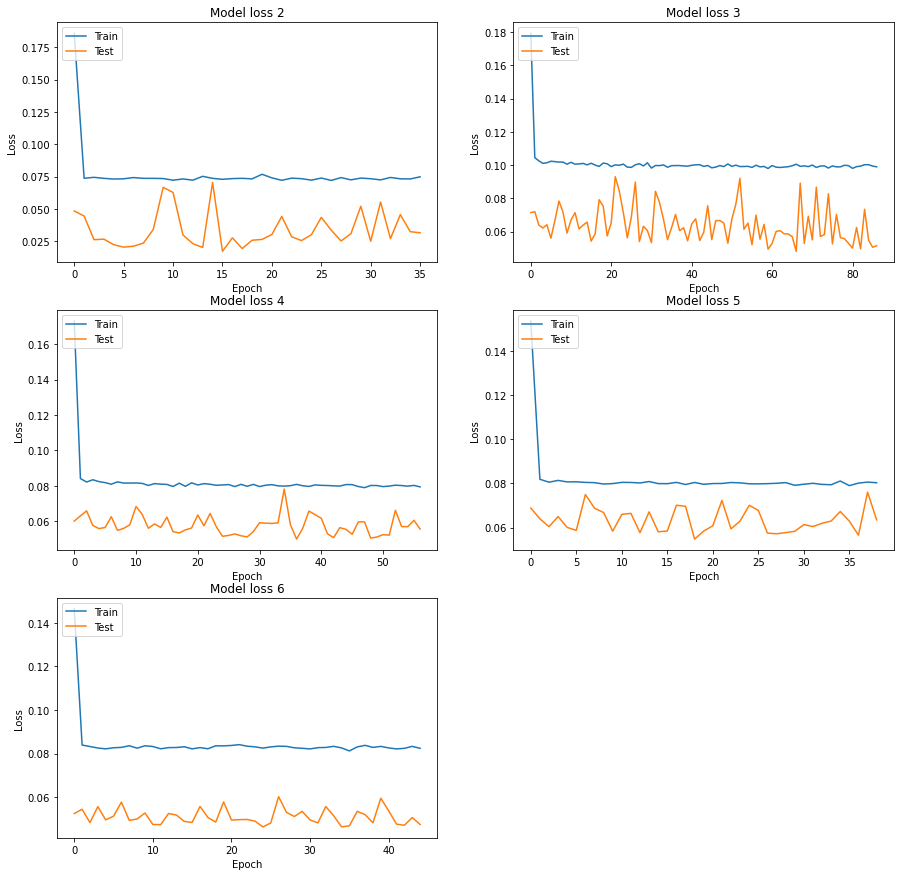

In [17]:
fig = plt.figure(figsize = (15, 15))
for i in range(5):
    fig.add_subplot(3, 2, i+1)
    plt.plot(history[i+2].history['loss'])
    plt.plot(history[i+2].history['val_loss'])
    plt.title('Model loss '+str(i+2))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')

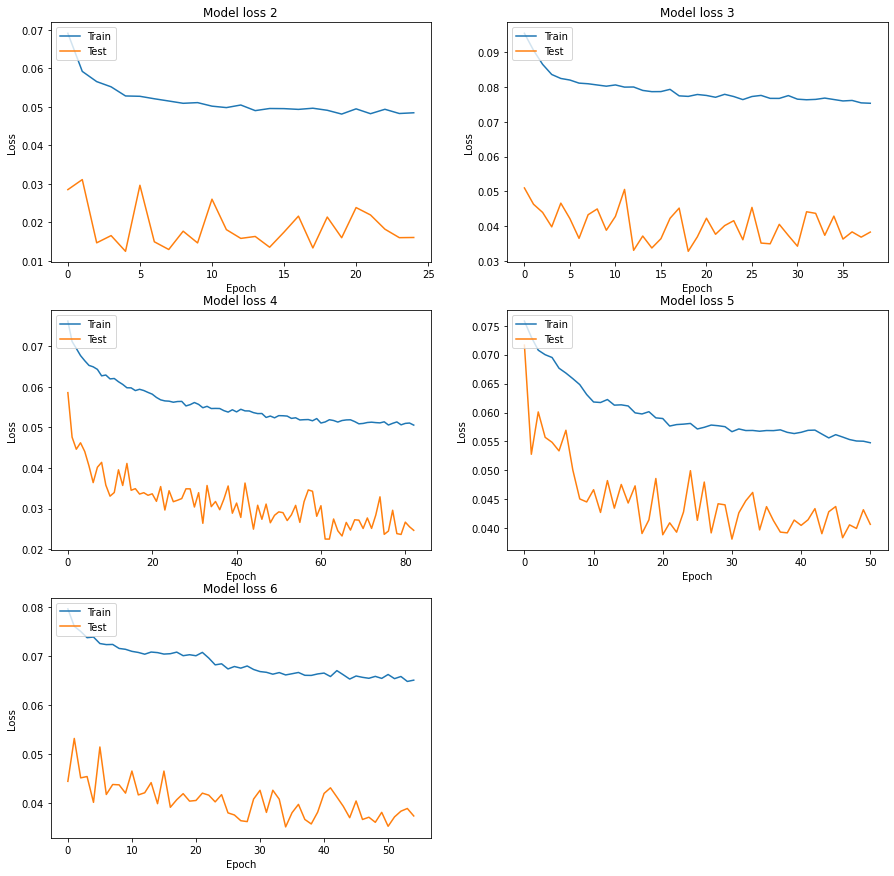

In [18]:
fig = plt.figure(figsize = (15, 15))
for i in range(5):
    fig.add_subplot(3, 2, i+1)
    plt.plot(history_ft[i+2].history['loss'])
    plt.plot(history_ft[i+2].history['val_loss'])
    plt.title('Model loss '+str(i+2))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')